# 3D Facial Reconstruction ECE 57000 Final Project

Note before running: Ensure you have at least 3 headshots in jpg form and verify paths of model and pictures

# 1. Preliminary Installation

Begin by installing mediapipe.  This is needed to train the landmark model. Additionally, please run

```
pip install requirements.txt
```

to install required modules

In [ ]:
!pip install mediapipe

# 2. Prepare Pre-trained Landmark Model

In [ ]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

def generate_landmarks(image_path):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image) # Convert PIL Image to NumPy array
    results = face_mesh.process(image)

    if results.multi_face_landmarks:
        landmarks = [[landmark.x * image.shape[1], landmark.y * image.shape[0]]
                     for landmark in results.multi_face_landmarks[0].landmark]
        return np.array(landmarks)
    else:
        return None

# 3. Prepare your own CNN Model and Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

class LandmarkModel(nn.Module):
  def __init__(self):
    super(LandmarkModel, self).__init__()
    base_model = resnet18(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
    self.fc = nn.Sequential(
        nn.Linear(base_model.fc.in_features, 256),
        nn.ReLU(),
        nn.Linear(256, 936)
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

class LFWDataset(Dataset):
  def __init__(self, image_path, landmarks, transform=None):
    self.image_path = image_path
    self.landmarks = landmarks
    self.transform = transform

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self, idx):
    img_path = self.image_path[idx]
    image = Image.open(img_path).convert("RGB")
    landmarks = generate_landmarks(img_path)

    if landmarks is not None:
      landmarks = landmarks.flatten()
      landmarks = landmarks / 96.0

      if self.transform:
        image = self.transform(image)

      return image, torch.tensor(landmarks, dtype=torch.float32)

    return None


transform = transforms.Compose([
  transforms.Resize((96, 96)),
  transforms.ToTensor()
])

image_paths = ['./drive/MyDrive/Pictures/img1.jpg', './drive/MyDrive/Pictures/img2.jpg', './drive/MyDrive/Pictures/img3.jpg']
landmarks = [[ # this is customizable
    # Jawline (1–80)
    0.10, 0.80, 0.11, 0.79, 0.12, 0.78, 0.13, 0.77, 0.14, 0.76,
    0.15, 0.75, 0.16, 0.74, 0.17, 0.73, 0.18, 0.72, 0.19, 0.71,
    0.20, 0.70, 0.21, 0.69, 0.22, 0.68, 0.23, 0.67, 0.24, 0.66,
    0.25, 0.65, 0.26, 0.64, 0.27, 0.63, 0.28, 0.62, 0.29, 0.61,
    0.30, 0.60, 0.31, 0.59, 0.32, 0.58, 0.33, 0.57, 0.34, 0.56,
    0.35, 0.55, 0.36, 0.54, 0.37, 0.53, 0.38, 0.52, 0.39, 0.51,
    0.40, 0.50, 0.41, 0.49, 0.42, 0.48, 0.43, 0.47, 0.44, 0.46,
    0.45, 0.45, 0.46, 0.44, 0.47, 0.43, 0.48, 0.42, 0.49, 0.41,

    # Left Eyebrow (81–160)
    0.20, 0.40, 0.21, 0.39, 0.22, 0.38, 0.23, 0.37, 0.24, 0.36,
    0.25, 0.35, 0.26, 0.34, 0.27, 0.33, 0.28, 0.32, 0.29, 0.31,
    0.30, 0.30, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34,
    0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39,

    # Right Eyebrow (161–240)
    0.60, 0.40, 0.61, 0.39, 0.62, 0.38, 0.63, 0.37, 0.64, 0.36,
    0.65, 0.35, 0.66, 0.34, 0.67, 0.33, 0.68, 0.32, 0.69, 0.31,
    0.70, 0.30, 0.71, 0.31, 0.72, 0.32, 0.73, 0.33, 0.74, 0.34,
    0.75, 0.35, 0.76, 0.36, 0.77, 0.37, 0.78, 0.38, 0.79, 0.39,

    # Nose (241–360)
    0.50, 0.45, 0.49, 0.44, 0.48, 0.43, 0.47, 0.42, 0.46, 0.41,
    0.45, 0.40, 0.50, 0.50, 0.50, 0.55, 0.50, 0.60, 0.49, 0.61,
    0.48, 0.62, 0.47, 0.63, 0.46, 0.64, 0.45, 0.65, 0.50, 0.65,
    0.51, 0.64, 0.52, 0.63, 0.53, 0.62, 0.54, 0.61, 0.55, 0.60,

    # Left Eye (361–440)
    0.30, 0.50, 0.31, 0.49, 0.32, 0.48, 0.33, 0.47, 0.34, 0.46,
    0.35, 0.45, 0.36, 0.46, 0.37, 0.47, 0.38, 0.48, 0.39, 0.49,
    0.40, 0.50, 0.39, 0.51, 0.38, 0.52, 0.37, 0.53, 0.36, 0.54,
    0.35, 0.55, 0.34, 0.54, 0.33, 0.53, 0.32, 0.52, 0.31, 0.51,

    # Right Eye (441–520)
    0.60, 0.50, 0.61, 0.49, 0.62, 0.48, 0.63, 0.47, 0.64, 0.46,
    0.65, 0.45, 0.66, 0.46, 0.67, 0.47, 0.68, 0.48, 0.69, 0.49,
    0.70, 0.50, 0.69, 0.51, 0.68, 0.52, 0.67, 0.53, 0.66, 0.54,
    0.65, 0.55, 0.64, 0.54, 0.63, 0.53, 0.62, 0.52, 0.61, 0.51,

    # Outer Lip (521–680)
    0.40, 0.70, 0.41, 0.69, 0.42, 0.68, 0.43, 0.67, 0.44, 0.66,
    0.45, 0.65, 0.46, 0.64, 0.47, 0.63, 0.48, 0.62, 0.49, 0.61,
    0.50, 0.60, 0.51, 0.61, 0.52, 0.62, 0.53, 0.63, 0.54, 0.64,
    0.55, 0.65, 0.56, 0.66, 0.57, 0.67, 0.58, 0.68, 0.59, 0.69,

    # Inner Lip (681–750)
    0.46, 0.70, 0.47, 0.69, 0.48, 0.68, 0.49, 0.67, 0.50, 0.66,
    0.51, 0.67, 0.52, 0.68, 0.53, 0.69, 0.54, 0.70, 0.53, 0.71,
    0.52, 0.72, 0.51, 0.73, 0.50, 0.74, 0.49, 0.73, 0.48, 0.72,

    # Cheeks (751–936)
    0.30, 0.60, 0.32, 0.58, 0.34, 0.56, 0.36, 0.54, 0.38, 0.52,
    0.40, 0.50, 0.42, 0.52, 0.44, 0.54, 0.46, 0.56, 0.48, 0.58,
    0.50, 0.60, 0.52, 0.62, 0.54, 0.64, 0.56, 0.66, 0.58, 0.68,
    0.60, 0.70, 0.62, 0.68, 0.64, 0.66, 0.66, 0.64, 0.68, 0.62,
    0.70, 0.60
], [
    # Jawline (1–80)
    0.10, 0.80, 0.11, 0.79, 0.12, 0.78, 0.13, 0.77, 0.14, 0.76,
    0.15, 0.75, 0.16, 0.74, 0.17, 0.73, 0.18, 0.72, 0.19, 0.71,
    0.20, 0.70, 0.21, 0.69, 0.22, 0.68, 0.23, 0.67, 0.24, 0.66,
    0.25, 0.65, 0.26, 0.64, 0.27, 0.63, 0.28, 0.62, 0.29, 0.61,
    0.30, 0.60, 0.31, 0.59, 0.32, 0.58, 0.33, 0.57, 0.34, 0.56,
    0.35, 0.55, 0.36, 0.54, 0.37, 0.53, 0.38, 0.52, 0.39, 0.51,
    0.40, 0.50, 0.41, 0.49, 0.42, 0.48, 0.43, 0.47, 0.44, 0.46,
    0.45, 0.45, 0.46, 0.44, 0.47, 0.43, 0.48, 0.42, 0.49, 0.41,

    # Left Eyebrow (81–160)
    0.20, 0.40, 0.21, 0.39, 0.22, 0.38, 0.23, 0.37, 0.24, 0.36,
    0.25, 0.35, 0.26, 0.34, 0.27, 0.33, 0.28, 0.32, 0.29, 0.31,
    0.30, 0.30, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34,
    0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39,

    # Right Eyebrow (161–240)
    0.60, 0.40, 0.61, 0.39, 0.62, 0.38, 0.63, 0.37, 0.64, 0.36,
    0.65, 0.35, 0.66, 0.34, 0.67, 0.33, 0.68, 0.32, 0.69, 0.31,
    0.70, 0.30, 0.71, 0.31, 0.72, 0.32, 0.73, 0.33, 0.74, 0.34,
    0.75, 0.35, 0.76, 0.36, 0.77, 0.37, 0.78, 0.38, 0.79, 0.39,

    # Nose (241–360)
    0.50, 0.45, 0.49, 0.44, 0.48, 0.43, 0.47, 0.42, 0.46, 0.41,
    0.45, 0.40, 0.50, 0.50, 0.50, 0.55, 0.50, 0.60, 0.49, 0.61,
    0.48, 0.62, 0.47, 0.63, 0.46, 0.64, 0.45, 0.65, 0.50, 0.65,
    0.51, 0.64, 0.52, 0.63, 0.53, 0.62, 0.54, 0.61, 0.55, 0.60,

    # Left Eye (361–440)
    0.30, 0.50, 0.31, 0.49, 0.32, 0.48, 0.33, 0.47, 0.34, 0.46,
    0.35, 0.45, 0.36, 0.46, 0.37, 0.47, 0.38, 0.48, 0.39, 0.49,
    0.40, 0.50, 0.39, 0.51, 0.38, 0.52, 0.37, 0.53, 0.36, 0.54,
    0.35, 0.55, 0.34, 0.54, 0.33, 0.53, 0.32, 0.52, 0.31, 0.51,

    # Right Eye (441–520)
    0.60, 0.50, 0.61, 0.49, 0.62, 0.48, 0.63, 0.47, 0.64, 0.46,
    0.65, 0.45, 0.66, 0.46, 0.67, 0.47, 0.68, 0.48, 0.69, 0.49,
    0.70, 0.50, 0.69, 0.51, 0.68, 0.52, 0.67, 0.53, 0.66, 0.54,
    0.65, 0.55, 0.64, 0.54, 0.63, 0.53, 0.62, 0.52, 0.61, 0.51,

    # Outer Lip (521–680)
    0.40, 0.70, 0.41, 0.69, 0.42, 0.68, 0.43, 0.67, 0.44, 0.66,
    0.45, 0.65, 0.46, 0.64, 0.47, 0.63, 0.48, 0.62, 0.49, 0.61,
    0.50, 0.60, 0.51, 0.61, 0.52, 0.62, 0.53, 0.63, 0.54, 0.64,
    0.55, 0.65, 0.56, 0.66, 0.57, 0.67, 0.58, 0.68, 0.59, 0.69,

    # Inner Lip (681–750)
    0.46, 0.70, 0.47, 0.69, 0.48, 0.68, 0.49, 0.67, 0.50, 0.66,
    0.51, 0.67, 0.52, 0.68, 0.53, 0.69, 0.54, 0.70, 0.53, 0.71,
    0.52, 0.72, 0.51, 0.73, 0.50, 0.74, 0.49, 0.73, 0.48, 0.72,

    # Cheeks (751–936)
    0.30, 0.60, 0.32, 0.58, 0.34, 0.56, 0.36, 0.54, 0.38, 0.52,
    0.40, 0.50, 0.42, 0.52, 0.44, 0.54, 0.46, 0.56, 0.48, 0.58,
    0.50, 0.60, 0.52, 0.62, 0.54, 0.64, 0.56, 0.66, 0.58, 0.68,
    0.60, 0.70, 0.62, 0.68, 0.64, 0.66, 0.66, 0.64, 0.68, 0.62,
    0.70, 0.60
], [
    # Jawline (1–80)
    0.10, 0.80, 0.11, 0.79, 0.12, 0.78, 0.13, 0.77, 0.14, 0.76,
    0.15, 0.75, 0.16, 0.74, 0.17, 0.73, 0.18, 0.72, 0.19, 0.71,
    0.20, 0.70, 0.21, 0.69, 0.22, 0.68, 0.23, 0.67, 0.24, 0.66,
    0.25, 0.65, 0.26, 0.64, 0.27, 0.63, 0.28, 0.62, 0.29, 0.61,
    0.30, 0.60, 0.31, 0.59, 0.32, 0.58, 0.33, 0.57, 0.34, 0.56,
    0.35, 0.55, 0.36, 0.54, 0.37, 0.53, 0.38, 0.52, 0.39, 0.51,
    0.40, 0.50, 0.41, 0.49, 0.42, 0.48, 0.43, 0.47, 0.44, 0.46,
    0.45, 0.45, 0.46, 0.44, 0.47, 0.43, 0.48, 0.42, 0.49, 0.41,

    # Left Eyebrow (81–160)
    0.20, 0.40, 0.21, 0.39, 0.22, 0.38, 0.23, 0.37, 0.24, 0.36,
    0.25, 0.35, 0.26, 0.34, 0.27, 0.33, 0.28, 0.32, 0.29, 0.31,
    0.30, 0.30, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34,
    0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39,

    # Right Eyebrow (161–240)
    0.60, 0.40, 0.61, 0.39, 0.62, 0.38, 0.63, 0.37, 0.64, 0.36,
    0.65, 0.35, 0.66, 0.34, 0.67, 0.33, 0.68, 0.32, 0.69, 0.31,
    0.70, 0.30, 0.71, 0.31, 0.72, 0.32, 0.73, 0.33, 0.74, 0.34,
    0.75, 0.35, 0.76, 0.36, 0.77, 0.37, 0.78, 0.38, 0.79, 0.39,

    # Nose (241–360)
    0.50, 0.45, 0.49, 0.44, 0.48, 0.43, 0.47, 0.42, 0.46, 0.41,
    0.45, 0.40, 0.50, 0.50, 0.50, 0.55, 0.50, 0.60, 0.49, 0.61,
    0.48, 0.62, 0.47, 0.63, 0.46, 0.64, 0.45, 0.65, 0.50, 0.65,
    0.51, 0.64, 0.52, 0.63, 0.53, 0.62, 0.54, 0.61, 0.55, 0.60,

    # Left Eye (361–440)
    0.30, 0.50, 0.31, 0.49, 0.32, 0.48, 0.33, 0.47, 0.34, 0.46,
    0.35, 0.45, 0.36, 0.46, 0.37, 0.47, 0.38, 0.48, 0.39, 0.49,
    0.40, 0.50, 0.39, 0.51, 0.38, 0.52, 0.37, 0.53, 0.36, 0.54,
    0.35, 0.55, 0.34, 0.54, 0.33, 0.53, 0.32, 0.52, 0.31, 0.51,

    # Right Eye (441–520)
    0.60, 0.50, 0.61, 0.49, 0.62, 0.48, 0.63, 0.47, 0.64, 0.46,
    0.65, 0.45, 0.66, 0.46, 0.67, 0.47, 0.68, 0.48, 0.69, 0.49,
    0.70, 0.50, 0.69, 0.51, 0.68, 0.52, 0.67, 0.53, 0.66, 0.54,
    0.65, 0.55, 0.64, 0.54, 0.63, 0.53, 0.62, 0.52, 0.61, 0.51,

    # Outer Lip (521–680)
    0.40, 0.70, 0.41, 0.69, 0.42, 0.68, 0.43, 0.67, 0.44, 0.66,
    0.45, 0.65, 0.46, 0.64, 0.47, 0.63, 0.48, 0.62, 0.49, 0.61,
    0.50, 0.60, 0.51, 0.61, 0.52, 0.62, 0.53, 0.63, 0.54, 0.64,
    0.55, 0.65, 0.56, 0.66, 0.57, 0.67, 0.58, 0.68, 0.59, 0.69,

    # Inner Lip (681–750)
    0.46, 0.70, 0.47, 0.69, 0.48, 0.68, 0.49, 0.67, 0.50, 0.66,
    0.51, 0.67, 0.52, 0.68, 0.53, 0.69, 0.54, 0.70, 0.53, 0.71,
    0.52, 0.72, 0.51, 0.73, 0.50, 0.74, 0.49, 0.73, 0.48, 0.72,

    # Cheeks (751–936)
    0.30, 0.60, 0.32, 0.58, 0.34, 0.56, 0.36, 0.54, 0.38, 0.52,
    0.40, 0.50, 0.42, 0.52, 0.44, 0.54, 0.46, 0.56, 0.48, 0.58,
    0.50, 0.60, 0.52, 0.62, 0.54, 0.64, 0.56, 0.66, 0.58, 0.68,
    0.60, 0.70, 0.62, 0.68, 0.64, 0.66, 0.66, 0.64, 0.68, 0.62,
    0.70, 0.60
]]

# Create and load the dataset
dataset = LFWDataset(image_paths, landmarks, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 4. Train the Model

In [ ]:
# Ensure device is using CUDA if accessible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is using {device}")
model = LandmarkModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Instantiate total epoch and total loss value
total_epochs = 50000
total_loss = 0.0

# Train the Model using CNN Approach
for epoch in range(total_epochs):
  model.train()
  running_loss = 0.0
  for images, landmarks in dataloader:
    images = images.to(device)
    landmarks = landmarks.to(device)

    outputs = model(images)
    loss = criterion(outputs, landmarks)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  if (epoch + 1) % 100 == 0:  # Print every 10000 epochs
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {running_loss/len(dataloader)}")
  total_loss += running_loss

print(f"Average Loss across all Epochs: {total_loss/total_epochs}")

device is using cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 100/50000, Loss: 0.0017200915608555079
Epoch 200/50000, Loss: 0.0009525416535325348
Epoch 300/50000, Loss: 0.0004943927633576095
Epoch 400/50000, Loss: 0.00020465994020923972
Epoch 500/50000, Loss: 6.850597128504887e-05
Epoch 600/50000, Loss: 2.1787969672004692e-05
Epoch 700/50000, Loss: 6.8830895543214865e-06
Epoch 800/50000, Loss: 2.2597705537918955e-06
Epoch 900/50000, Loss: 1.8244613784190733e-06
Epoch 1000/50000, Loss: 2.724471244164306e-07
Epoch 1100/50000, Loss: 9.619656538006893e-08
Epoch 1200/50000, Loss: 3.358909239636887e-08
Epoch 1300/50000, Loss: 1.1367831120878691e-08
Epoch 1400/50000, Loss: 3.6855323237716675e-09
Epoch 1500/50000, Loss: 1.134169314020994e-09
Epoch 1600/50000, Loss: 3.298468720380754e-10
Epoch 1700/50000, Loss: 0.0007620544056408107
Epoch 1800/50000, Loss: 2.9795005573873823e-08
Epoch 1900/50000, Loss: 3.421997407659916e-10
Epoch 2000/50000, Loss: 3.8002344326937276e-11
Epoch 2100/50000, Loss: 4.872744135270279e-12
Epoch 2200/50000, Loss: 7.47288244

# 5. Test the Model's Accuracy

In [ ]:
import numpy as np

def calculate_accuracy(model, dataloader, device):
  """Calculates the average landmark prediction accuracy.

  Args:
    model: The trained landmark model.
    dataloader: DataLoader for the test dataset.
    device: The device (CPU or GPU) to run the model on.

  Returns:
    The average accuracy across all test samples.
  """
  model.eval()  # Set the model to evaluation mode
  total_distance = 0
  total_samples = 0

  with torch.no_grad():
    for images, true_landmarks in dataloader:
      images = images.to(device)
      true_landmarks = true_landmarks.to(device)

      predicted_landmarks = model(images)

      # Calculate Euclidean distance between predicted and true landmarks
      distance = torch.sqrt(torch.sum((predicted_landmarks - true_landmarks)**2, dim=1))
      total_distance += torch.sum(distance).item()  # Accumulate total distance
      total_samples += images.shape[0]  # Accumulate total samples

  average_distance = total_distance / total_samples  # Calculate average distance
  accuracy = 1 / (1 + average_distance)

  return accuracy

# Example usage:
test_dataset = LFWDataset(image_paths, landmarks, transform) # Assuming your test dataset and paths
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy = calculate_accuracy(model, test_dataloader, device)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 20.79913950500115%


# 6. Run the Model's Prediction

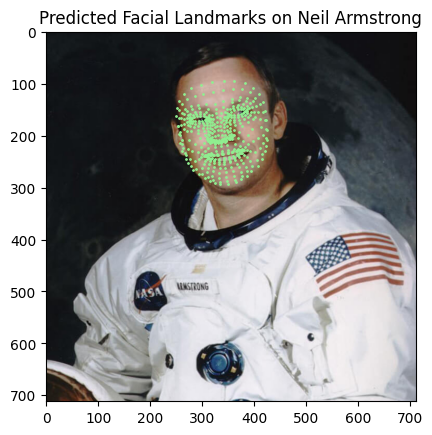

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def predict_and_visualize(image_path, model):
  """Predicts landmarks on a single image and visualizes them.

  Args:
    image_path: Path to the input image.
    model: The trained landmark model.
  """
  # 1. Load and Preprocess Image
  image = Image.open(image_path).convert("RGB")
  transform = transforms.Compose([
      transforms.Resize((96, 96)),
      transforms.ToTensor()
  ])
  input_image = transform(image).unsqueeze(0).to(device)

  # 2. Make Predictions
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    prediction = model(input_image).cpu().numpy().reshape(-1, 2) * 96

  # 3. Visualize Predictions
  plt.imshow(image, cmap='gray')
  plt.title("Predicted Facial Landmarks on Neil Armstrong")
  for x, y in prediction:
    plt.plot(x, y, 'o', markersize=1, color='lightgreen')
  plt.show()

# Example usage:
image_path = './drive/MyDrive/Pictures/img2.jpg'
predict_and_visualize(image_path, model)
torch.save(model, 'drive/MyDrive/landmark_model_468.pth')

# 7. Run the Model on Yourself

In [36]:
import cv2
import time

# Load the trained model weights (same as before)
loaded_model = torch.load('drive/MyDrive/landmark_model_468.pth')
model.load_state_dict(loaded_model.state_dict())
model.eval()

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Variables for FPS calculation
prev_frame_time = 0
new_frame_time = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # FPS Calculation (same as before)
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps = str(fps)
    cv2.putText(frame, fps, (7, 70), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 3, cv2.LINE_AA)

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize the frame to 96x96
    frame_resized = cv2.resize(frame_rgb, (96, 96))

    # Transform the frame for the model
    input_image = transform(Image.fromarray(frame_resized)).unsqueeze(0).to(device)

    # Perform prediction using the loaded model
    with torch.no_grad():
        prediction = model(input_image).cpu().numpy().reshape(-1, 2) * 96

    # Draw the landmarks on the original frame
    for x, y in prediction:
        cv2.circle(frame, (int(x), int(y)), 1, (0, 255, 0), -1)  # Green circles

    # Display the frame
    cv2.imshow("Webcam Landmarks", frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

<ipython-input-36-0c97209e6235>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('drive/MyDrive/landmark_model_468.pth')
